<b> EBCMS (Energy-Balance Climate Model with Seasons) </b><br>
Reference: Walter A. Robinson, Modeling Dynamic Climate Systems

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-dark')

In [2]:
# Step size          
dt = 0.001

# Set up simulation time
tmin = 0
tmax = 6
t = np.arange(tmin, tmax + dt, dt)
n = len(t)

# Seconds per year
seconds_per_year = 365 * 24 * 60 * 60

In [3]:
# Constants for parameterized infrared cooling rate equation IR = a x T + b
a = 3.18 # W/m^2/K
b = -669.8 # W/m^2

# Albedo
albedo_temperate = 0.4
albedo_tropics = 0.2

# Specific heat capacity of atmosphere
spec_heat_atm = 1004 # J/kg*K

# Density of water
water_density = 1000 # kg/m^3

# Depth of the mixed layer
depth_mixed_layer = 50 # m

# Gravity accelleration
g = 9.81 # m/s^2

# Latent heat of vaporization
lv = 2500000 # J/kg

# Atmospheric pressure
p0 = 1e5; # Pa

# Relative humidity
rh = 0.5

# Earth radius
earth_radius = 6.37e6 # m

# Earth area
earth_area = np.pi * (earth_radius) ** 2 # m^2

# Specific heat capacity of water
spec_heat_water = 4218 # J/kg*K

# Solar constant 
solar_const = 1367 # W/m^2

temperate_coeff = 0.196
tropics_coeff = 0.304

# Mixing velocity
mixing_velocity = 0.8 # m/s

# Mixing velocity Ocean - land
mixing_velocity_ocean_land = 2 # m/s

In [4]:
# Heat capacity (Tropics, land, ocean)
heat_capacity_tropics = 2 * water_density * depth_mixed_layer * spec_heat_water # J/K
heat_capacity_land = heat_capacity_tropics * 2.5/depth_mixed_layer/2 # J/K
heat_capacity_ocean = heat_capacity_tropics/2 # J/K

# Mixing coeffiecients
mixing_coef_tropics_temperate = mixing_velocity * p0/g * np.pi * earth_radius * spec_heat_atm * seconds_per_year/earth_area
mixing_coef_ocean_land = mixing_velocity_ocean_land * mixing_coef_tropics_temperate/mixing_velocity

# Incoming solar radiation
s0_land = (solar_const * temperate_coeff * seconds_per_year * (1 - albedo_temperate)) * (1 + 0.6 * np.cos(2 * np.pi * (t + 0.5))) 
s0_trop = (2 * solar_const * tropics_coeff * seconds_per_year * (1- albedo_tropics)) * (1 + 0.13 * np.cos(2 * np.pi * (t + 0.5)))
s0_ocean = s0_land

In [5]:
# Inizialize temperature (Land, Ocean, Tropics)
T_land = np.zeros((n, ))
T_land[0] = 288
T_ocean = np.zeros((n, ))
T_ocean[0] = 288
T_tropics = np.zeros((n, ))
T_tropics[0] = 288

# Initialize Energy fluxes
energy_tropics_to_land = np.zeros((n, ))
energy_tropics_to_land[0] = mixing_coef_tropics_temperate *  (T_tropics[0] - (T_land[0] + T_ocean[0])/2)

energy_tropics_to_ocean = np.zeros((n, ))
energy_tropics_to_ocean[0] = energy_tropics_to_land[0]

energy_land_to_ocean = np.zeros((n, ))
energy_land_to_ocean[0] = mixing_coef_ocean_land *  (T_land[0] - T_ocean[0])

# Initialize IR
IR_trop = np.zeros((n, ))
IR_trop[0] = 2*(a * T_tropics[0] + b) * seconds_per_year
IR_ocean = np.zeros((n, ))
IR_ocean[0] = (a * T_ocean[0] + b) * seconds_per_year
IR_land = np.zeros((n, ))
IR_land[0] = (a * T_land[0] + b) * seconds_per_year

# Storage of heat (Ocean)
ocean_storage = np.zeros((n, ))

# Energy budget (incoming-emitted)
eb_land = np.zeros((n, ))
eb_ocean = np.zeros((n, ))

In [6]:
for k in range(1, n):
    # Calculate temperature
    T_land[k] = T_land[k-1] + (energy_tropics_to_land[k-1] + s0_land[k] - IR_land[k-1] - energy_land_to_ocean[k-1]) * dt/heat_capacity_land
    T_ocean[k] = T_ocean[k-1] + (energy_tropics_to_ocean[k-1] + s0_ocean[k] + energy_land_to_ocean[k-1] - IR_ocean[k-1]) * dt/heat_capacity_ocean
    T_tropics[k] = T_tropics[k-1] + (s0_trop[k] - energy_tropics_to_land[k-1] - IR_trop[k-1] - energy_tropics_to_ocean[k-1]) * dt/heat_capacity_tropics

    # Calculate IR
    IR_trop[k] = 2 * (a * T_tropics[k] + b) * seconds_per_year
    IR_ocean[k] = (a * T_ocean[k] + b) * seconds_per_year
    IR_land[k] = (a * T_land[k] + b) * seconds_per_year

    # Calculate Energy Fluxes
    energy_tropics_to_land[k] = mixing_coef_tropics_temperate *  (T_tropics[k-1] - (T_land[k-1] + T_ocean[k])/2)
    energy_tropics_to_ocean[k] = energy_tropics_to_land[k]
    energy_land_to_ocean[k] = mixing_coef_ocean_land *  (T_land[k] - T_ocean[k])

    # Calculate Storage of heat (Ocean)
    ocean_storage[k] = -((T_ocean[k] - T_ocean[k-1]) * heat_capacity_ocean/dt/seconds_per_year)

    # Energy budget (incoming-emitted)
    eb_land[k] = (s0_land[k] - IR_land[k])/seconds_per_year
    eb_ocean[k] = (s0_ocean[k] - IR_ocean[k])/seconds_per_year

In [7]:
# Energy transport
trans_ocean_land = - energy_land_to_ocean/seconds_per_year
trans_land_ocean = - trans_ocean_land
trans_trop_land = energy_tropics_to_land/seconds_per_year

# K to °C
T_land = T_land - 273.15
T_ocean = T_ocean - 273.15
T_tropics =  T_tropics - 273.15

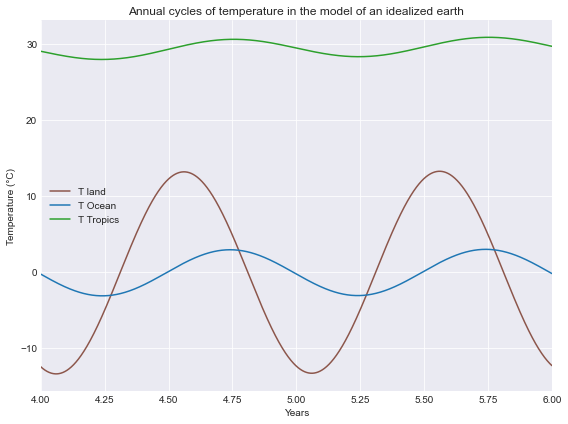

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(t, T_land, c="tab:brown")
ax.plot(t, T_ocean, c="tab:blue")
ax.plot(t, T_tropics, c="tab:green")
ax.set_title("Annual cycles of temperature in the model of an idealized earth")
ax.set_xlim(4, 6)
ax.set_xlabel("Years")
ax.set_ylabel("Temperature (°C)")
ax.legend(["T land", "T Ocean", "T Tropics"])
ax.grid()
plt.tight_layout()
plt.show()

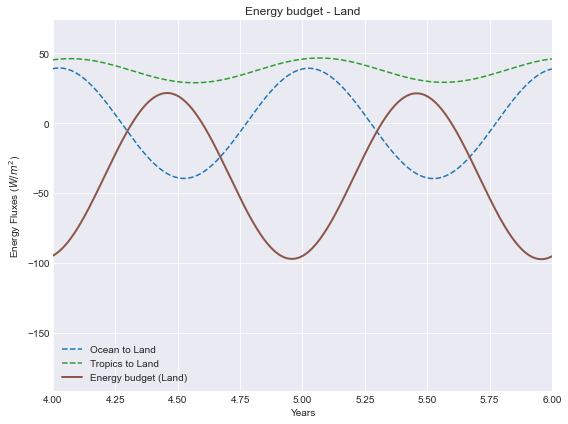

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(t, trans_ocean_land, c="tab:blue", linestyle="dashed")
ax.plot(t, trans_trop_land, c="tab:green", linestyle="dashed")
ax.plot(t, eb_land, c="tab:brown", lw=2)
ax.set_title("Energy budget - Land")
ax.set_xlim(4, 6)
ax.set_xlabel("Years")
ax.set_ylabel("Energy Fluxes ($W/m^{2}$)")
ax.legend(["Ocean to Land", "Tropics to Land", "Energy budget (Land)"])
ax.grid()
plt.tight_layout()
plt.show()

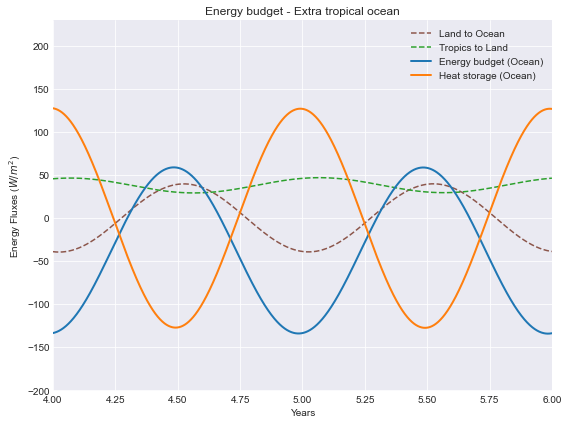

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(t, trans_land_ocean, c="tab:brown", linestyle="dashed")
ax.plot(t, trans_trop_land, c="tab:green", linestyle="dashed")
ax.plot(t, eb_ocean, c="tab:blue", lw=2)
ax.plot(t, ocean_storage, c="tab:orange", lw=2)
ax.set_title("Energy budget - Extra tropical ocean")
ax.set_xlim(4, 6)
ax.set_xlabel("Years")
ax.set_ylabel("Energy Fluxes ($W/m^{2}$)")
ax.legend(["Land to Ocean", "Tropics to Land", "Energy budget (Ocean)", "Heat storage (Ocean)"])
ax.grid()
plt.tight_layout()
plt.show()